<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Rllib_MultiAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import clip
  from plot_image_grid import image_grid
  import ray
except ModuleNotFoundError:
  !pip install gym==0.21.0
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  !pip install ray
  !pip install lz4

In [7]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'


!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [8]:
import pytorch3d
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [9]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [10]:
import copy

from pytorch3d.renderer import (
  HardPhongShader
)

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      # print(value, self._position)
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = copy.deepcopy(self._position)
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self._position = copy.deepcopy(self._prev_position)

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device
    

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 5.0, 7.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=128, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [11]:
from itertools import product

DIRECTIONS = list(product(range(-1, 2), repeat=3))
mod = 0.2
ALL_DIRECTIONS = [[a * mod for a in b] for b in DIRECTIONS]
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

In [12]:
CAMERA_CONFIG = {
  'azim': torch.linspace(0, 180, 4),
  'elev': [50],
  'dist': 20.0
}

GUIDE = "Pieces of fruit on top of a wooden table"

In [13]:
from copy import deepcopy

def get_scene(objs, obs):
  objs = deepcopy(objs)
  for i, obj in enumerate(objs):
    obj.position = obs[i]
  scene = Scene([a.mesh for a in objs], **CAMERA_CONFIG)
  return scene.render(), scene.scene[0]

In [14]:
import gym
from ray.rllib.env.env_context import EnvContext
import numpy as np
import os
import random

LIMIT_BOX = [[-10,-1,-10],[10,10,10]]

class S2A(gym.Env):
  def __init__(self, obj, limit=None, config: EnvContext = None):
    self.obj = obj
    self.cur_pos = [0,0,0]
    self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    self.observation_space = gym.spaces.Box(-12, 12, shape=(3,), dtype=np.float32)
    self.limit = limit
    self.rounds = 0

  def reset(self):
    self.cur_pos = [0,0,0]
    self.obj.position = self.cur_pos
    return self.cur_pos

  def step(self, action):
    self.rounds+=1
    rw = 1
    action = ACTIONS_MAP[action]
    new_pos = [a+b for a,b in zip (self.cur_pos, action)]
    for i, val in enumerate(new_pos):
      if val < LIMIT_BOX[0][i] or val > LIMIT_BOX[1][i]:
        rw = 0
        new_pos[i] = self.cur_pos[i]
    self.cur_pos = new_pos
    self.obj.translate(action)
    # Produce a random reward when we reach the goal.
    done = False
    if self.limit != None:
      if self.rounds >= self.limit:
        done = True
    return self.cur_pos, rw, done, {}

In [27]:
test_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
test_object = SceneObject(test_mesh, scale=0.25)

In [29]:
env = S2A(test_object)

In [30]:
observation= env.reset()

In [31]:
for _ in range(10):
  observation, reward, done, info = env.step(env.action_space.sample())
  print(observation)
  if done:
      observation = env.reset()

[0.0, 0.2, 0.0]
[0.0, 0.4, -0.2]
[0.0, 0.4, 0.0]
[0.0, 0.6000000000000001, -0.2]
[0.0, 0.8, -0.4]
[0.2, 1.0, -0.2]
[0.2, 1.0, 0.0]
[0.0, 0.8, 0.2]
[0.0, 1.0, 0.0]
[-0.2, 1.0, 0.2]


In [15]:
import gym
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from PIL import Image
from scipy.stats import mannwhitneyu

class RoundRobinMultiAgent(MultiAgentEnv):
  """Env of N independent agents, each of which exits after 5 steps.
  On each step() of the env, only one agent takes an action."""

  def __init__(self):
    super().__init__()

    fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

    fruit_object = SceneObject(fruit_mesh, scale=0.25)
    fruit_objectB = SceneObject(fruit_mesh, scale=0.25)
    table_object = SceneObject(table_mesh, scale=8)

    objs = [fruit_object,fruit_objectB, table_object]
    self.input_objs = deepcopy(objs)

    self.num = len(self.input_objs)
    self.agents = [S2A(self.input_objs[i]) for i in range(self.num)]
    self._agent_ids = set(range(self.num))
    self.dones = set()
    self.last_obs = {}
    self.last_rew = {}
    self.last_done = {}
    self.last_info = {}
    self.i = 0
    self.observation_space = gym.spaces.Box(-12, 12, shape=(3,), dtype=np.float32)
    self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
    self.best_sim_matrix = np.zeros(4).astype(np.float32)
    self.prev_sim_matrix = np.zeros(4).astype(np.float32)
    self.best_obs = {}
    self.model, self.preprocess = self.clip_model()

  def clip_model(self):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.cuda().eval()
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    return model, preprocess

  def get_pil_image(self, input):
    return Image.fromarray((input * 255).astype('uint8'))

  def clip_sim_3(self, input: list, description: str):
    text = clip.tokenize(description).to(device)
    with torch.no_grad():
      text_features = self.model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = []
    for image_input in input:
      # image_input = get_pil_image(image_input[0, ..., :3])
      image_input = self.preprocess(image_input).unsqueeze(0).to(device)

      with torch.no_grad():
        image_features = self.model.encode_image(image_input).float()

      image_features /= image_features.norm(dim=-1, keepdim=True)
      similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
      # print(similarity[0][0])
      similarities.append(similarity[0][0])
    return similarities

  def perform_test(self, a, b):
    stat, p = mannwhitneyu(a, b, alternative='greater',method='exact')
    return stat, p

  def render_scene_and_score(self, in_objs):
    scene_input = [obj.mesh for obj in in_objs]
    scene = Scene(scene_input, **CAMERA_CONFIG)
    images = scene.render()
    pil_images = [self.get_pil_image(img[..., :3]) for img in images]
    return self.clip_sim_3(pil_images, GUIDE)

  def reset(self):
    self.dones = set()
    self.best_obs = {}
    self.last_obs = {}
    self.last_rew = {}
    self.last_done = {}
    self.last_info = {}
    self.i = 0
    for i, a in enumerate(self.agents):
      self.last_obs[i] = a.reset()
      self.last_rew[i] = 0
      self.last_done[i] = False
      self.last_info[i] = {}
    obs_dict = {self.i: self.last_obs[self.i]}
    self.i = (self.i + 1) % self.num
    return obs_dict

  def get_reward(self, sim_matrix) -> int:
    rw = 0

    stat_best, p_best = self.perform_test(sim_matrix, self.best_sim_matrix)
    stat_prev, p_prev = self.perform_test(sim_matrix, self.prev_sim_matrix)

    if p_best <= 0.1:
      self.best_sim_matrix = sim_matrix
      self.best_obs = self.last_obs

    rw += 1-p_best
    rw += 1-p_prev

    rw = (2 *(rw - -2)/(2- -2)) - 1

    self.prev_sim_matrix = sim_matrix

    return rw

  def step(self, action_dict):
    assert len(self.dones) != len(self.agents)

    score = self.render_scene_and_score(self.input_objs)
    reward = self.get_reward(score)

    for i, action in action_dict.items():
      (
        self.last_obs[i],
        self.last_rew[i],
        self.last_done[i],
        self.last_info[i],
      ) = self.agents[i].step(action)
    obs = {self.i: self.last_obs[self.i]}
    rew = {self.i: self.last_rew[self.i] * reward}
    done = {self.i: self.last_done[self.i]}
    info = {self.i: self.last_info[self.i]}
    if done[self.i]:
      rew[self.i] = 0
      self.dones.add(self.i)
    self.i = (self.i + 1) % self.num
    done["__all__"] = len(self.dones) == len(self.agents)
    return obs, rew, done, info

In [25]:
multi_env = RoundRobinMultiAgent()

In [26]:
obs = multi_env.reset()

for i in range(10):
  obs, rew, done, info = multi_env.step({i: multi_env.action_space.sample() for i in range(len(multi_env.input_objs))})

In [27]:
from torch import cuda
cuda.empty_cache()

In [28]:
multi_env.best_obs

{0: [0.20000000000000007, 0.4000000000000001, 0.2],
 1: [0.4, 0.8, 0.8],
 2: [-0.2, -0.2, 0.4]}

In [29]:
images, scene = get_scene(multi_env.input_objs, multi_env.best_obs)

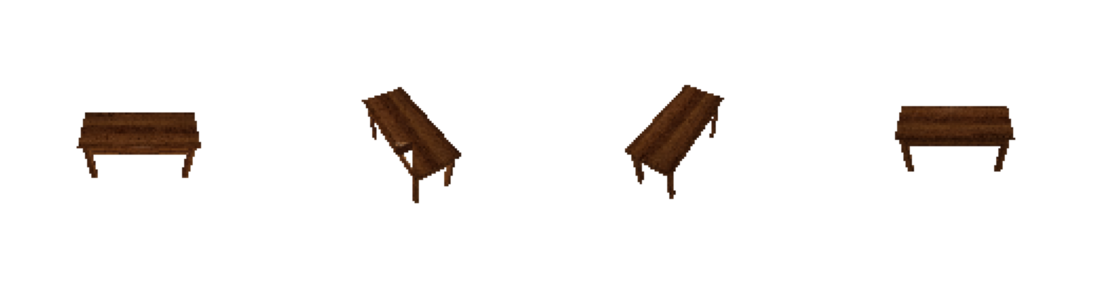

In [30]:
image_grid(images, rows=1, cols=4, rgb=True)

In [ ]:
plot_batch_individually(scene)

In [16]:
if not nb_path in os.environ['PYTHONPATH']:
  os.environ['PYTHONPATH'] += ':'+ nb_path

In [17]:
import ray
import ray.rllib.agents.ppo as ppo

ray.shutdown()
ray.init(ignore_reinit_error=True)

RayContext(dashboard_url='', python_version='3.7.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-20_18-47-15_971836_599/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-20_18-47-15_971836_599/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-08-20_18-47-15_971836_599', 'metrics_export_port': 59563, 'gcs_address': '172.28.0.2:56565', 'address': '172.28.0.2:56565', 'node_id': '36aacc794f9c1dacfbe3b2aab6a248ddd6203f7240341278d29d34ad'})

In [18]:
from ray.tune.registry import register_env

def env_creator(args):
  return RoundRobinMultiAgent()

env = env_creator({})
register_env("clip_guided", env_creator)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 40.1MiB/s]


In [26]:
config = ppo.DEFAULT_CONFIG.copy()

In [31]:
config.update({
    "num_workers": 0,
    "num_gpus": 1
})

In [32]:
trainer = ppo.PPOTrainer(config, env='clip_guided')

2022-08-20 19:00:57,886	WARNING multi_agent_env.py:225 -- observation_space_sample() has not been implemented
2022-08-20 19:00:58,199	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-20 19:00:58,200	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-20 19:00:58,201	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-20 19:00:58,203	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-08-20 19:00:58,204	WARNING multi_agent_env.py:161 -- action_space_contains() has not been implemented
2022-08-20 19:01:07,077	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-08-20 19:01:09,566	INFO trainable.py:156 -- Trainable.setup took 16.669 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-08-20 19:01:09,568	WARNING 